# 3 a.py

In [1]:
#Imports of needed modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

#Load the datasets
dataset = pd.read_csv('/content/spaceship-titanic.csv')
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=1)

In [3]:
#Print the first 5 rows of data so we can see what we're working with
print(train_dataset.head(5))

     PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
5776     6118_02       Mars      True   E/391/P  TRAPPIST-1e  39.0  False   
220      0234_01      Earth     False    F/50/P  TRAPPIST-1e  43.0  False   
2398     2580_01      Earth     False   G/412/S  TRAPPIST-1e  24.0  False   
5876     6224_01      Earth     False  F/1191/S  TRAPPIST-1e  16.0  False   
192      0213_01      Earth     False    F/46/P  TRAPPIST-1e  21.0  False   

      RoomService  FoodCourt  ShoppingMall   Spa  VRDeck            Name  \
5776          0.0        0.0           0.0   0.0     0.0       Tyog Pité   
220           NaN      888.0           0.0   0.0     0.0    Keitha Josey   
2398         19.0      676.0           0.0  26.0     0.0   Gretty Pentss   
5876          0.0        0.0          60.0   0.0  1963.0    Loree Rodger   
192         367.0      281.0           0.0   0.0   146.0  Carita Navages   

      Transported  
5776        False  
220         False  
2398        False  


In [4]:
#Since cabins and names vary and are not a good pick for the features we will drop them
print("Number of total rows in the DataFrame: " + str(train_dataset.shape[0]))
print("Number of unique cabins: " + str(train_dataset['Cabin'].unique().size))
print("Number of unique names: " + str(train_dataset['Name'].unique().size))

Number of total rows in the DataFrame: 6954
Number of unique cabins: 5430
Number of unique names: 6783


In [5]:
cols_to_drop = ['Cabin', 'Name']

train_dataset = train_dataset.drop(cols_to_drop, axis=1)
test_dataset = test_dataset.drop(cols_to_drop, axis=1)

In [6]:
#We're gonna go with the imputing method for null values 
from sklearn.impute import SimpleImputer

#We want to remove passenger id so we can impute our data
train_dataset_imputed = train_dataset.copy()
test_dataset_imputed = test_dataset.copy()

#We put the strategy to most_frequent because we have categorical columns
#for which we cannot calculate the mean
imputer = SimpleImputer(strategy='most_frequent')
train_dataset_imputed = pd.DataFrame(imputer.fit_transform(train_dataset))
test_dataset_imputed = pd.DataFrame(imputer.fit_transform(test_dataset))

#Imputation removes column names so we put them back in
train_dataset_imputed.columns = train_dataset.columns
test_dataset_imputed.columns = test_dataset.columns

In [8]:
#Defining categorical cols to be regulated
cols_to_one_hot_encode = ['HomePlanet', 'Destination']
bools_to_be_encoded = ['CryoSleep', 'VIP', 'Transported']

In [9]:
#One hot encoding
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

#Grab the one hot encoded cols
one_hot_train_cols = pd.DataFrame(one_hot_encoder.fit_transform(train_dataset_imputed[cols_to_one_hot_encode]))
one_hot_test_cols = pd.DataFrame(one_hot_encoder.fit_transform(test_dataset_imputed[cols_to_one_hot_encode]))

#Remove the cols that we one hot encode so we can add the encoded ones(right above)
one_hot_train_dataset = train_dataset_imputed.drop(cols_to_one_hot_encode, axis=1)
one_hot_test_dataset = test_dataset_imputed.drop(cols_to_one_hot_encode, axis=1)

#Now add those encoded cols to the previous dataset
one_hot_train_dataset = pd.concat([one_hot_train_dataset, one_hot_train_cols], axis=1)
one_hot_test_dataset = pd.concat([one_hot_test_dataset, one_hot_test_cols], axis=1)

#Encode boolean values into one's and zero's
for col in bools_to_be_encoded:
  one_hot_train_dataset[col] = one_hot_train_dataset[col].replace({True: 1, False: 0})
  one_hot_test_dataset[col] = one_hot_test_dataset[col].replace({True: 1, False: 0})

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
#This is what our data looks like right now, all digits :)
print(one_hot_train_dataset.head(5))

  PassengerId  CryoSleep   Age  VIP RoomService FoodCourt ShoppingMall   Spa  \
0     6118_02          1  39.0    0         0.0       0.0          0.0   0.0   
1     0234_01          0  43.0    0         0.0     888.0          0.0   0.0   
2     2580_01          0  24.0    0        19.0     676.0          0.0  26.0   
3     6224_01          0  16.0    0         0.0       0.0         60.0   0.0   
4     0213_01          0  21.0    0       367.0     281.0          0.0   0.0   

   VRDeck  Transported    0    1    2    3    4    5  
0     0.0            0  0.0  0.0  1.0  0.0  0.0  1.0  
1     0.0            0  1.0  0.0  0.0  0.0  0.0  1.0  
2     0.0            0  1.0  0.0  0.0  0.0  0.0  1.0  
3  1963.0            0  1.0  0.0  0.0  0.0  0.0  1.0  
4   146.0            0  1.0  0.0  0.0  0.0  0.0  1.0  


In [11]:
#It is specified in the assignment that we use only RoomService and FoodCourt so
#we will drop all the other cols

cols_to_drop = [col for col in one_hot_train_dataset
                if col not in ["RoomService", "FoodCourt", "Transported"]]

train_dataset_final = one_hot_train_dataset.drop(cols_to_drop, axis=1)
test_dataset_final = one_hot_test_dataset.drop(cols_to_drop, axis=1)

In [13]:
import seaborn as sn

class KNN:
  
    def __init__(self, nb_features, nb_classes, data, k, weighted = False):
        self.nb_features = nb_features
        self.nb_classes = nb_classes
        self.k = k
        self.weighted = weighted
        self.X = tf.convert_to_tensor(data['x'], dtype=tf.float32)
        self.Y = tf.convert_to_tensor(data['y'], dtype=tf.int32)
  
    # Ako imamo odgovore za upit racunamo i accuracy.
    def predict(self, query_data):
        
        # Pokretanje na svih 10000 primera bi trajalo predugo,
        # pa pokrecemo samo prvih 100.
        nb_queries = 100
        
        matches = 0
        for i in range(nb_queries):

            # Racunamo kvadriranu euklidsku udaljenost i uzimamo minimalnih k.
            dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, query_data['x'].iloc[i])), axis=1))
            _, idxs = tf.nn.top_k(-dists, self.k)

            classes = tf.gather(self.Y, idxs)
            dists = tf.gather(dists, idxs)
            
            if self.weighted:
                w = 1 / dists  # Paziti na deljenje sa nulom.
            else:
                w = tf.fill([self.k], 1/self.k)

            # Svaki red mnozimo svojim glasom i sabiramo glasove po kolonama.
            w_col = tf.reshape(w, (self.k, 1))
            classes_one_hot = tf.one_hot(classes, self.nb_classes)
            scores = tf.reduce_sum(w_col * classes_one_hot, axis=0)
            
            # Klasa sa najvise glasova je hipoteza.
            hyp = tf.argmax(scores)

            if query_data['y'] is not None:
                actual = query_data['y'].iloc[i]
                match = (hyp == actual)
                if match:
                    matches += 1
                if i % 10 == 0:
                    print(f'Test example: {i+1:2}/{nb_queries} | Predicted: {hyp} | Actual: {actual} | Match: {match}')
        
        accuracy = matches / nb_queries
        print(f'{matches} matches out of {nb_queries} examples')
        print(f'Test set accuracy: {accuracy}')

        #Now to visualize the data
        sn.scatterplot(x=train_dataset['RoomService'], y=train_dataset['FoodCourt'],
                  hue=train_dataset['Transported'])
    

Test example:  1/100 | Predicted: 1 | Actual: 1 | Match: True
Test example: 11/100 | Predicted: 0 | Actual: 0 | Match: True
Test example: 21/100 | Predicted: 1 | Actual: 1 | Match: True
Test example: 31/100 | Predicted: 0 | Actual: 0 | Match: True
Test example: 41/100 | Predicted: 1 | Actual: 1 | Match: True
Test example: 51/100 | Predicted: 1 | Actual: 1 | Match: True
Test example: 61/100 | Predicted: 1 | Actual: 1 | Match: True
Test example: 71/100 | Predicted: 0 | Actual: 0 | Match: True
Test example: 81/100 | Predicted: 1 | Actual: 1 | Match: True
Test example: 91/100 | Predicted: 0 | Actual: 0 | Match: True
74 matches out of 100 examples
Test set accuracy: 0.74


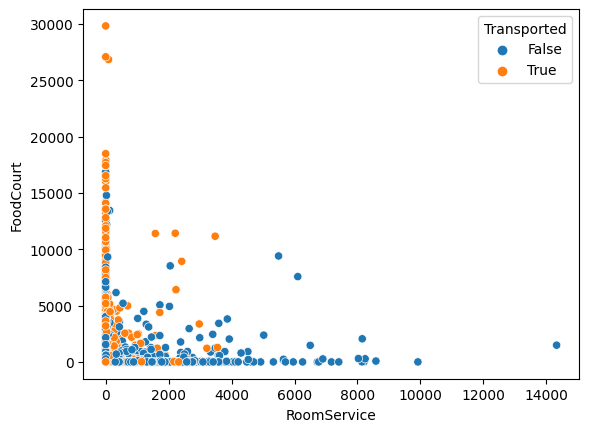

In [14]:
#We split the train data into features(x) and the target(y)
train_x = train_dataset_final.drop(['Transported'], axis=1)
train_y = train_dataset_final.Transported

test_x = test_dataset_final.drop(['Transported'], axis=1)
test_y = test_dataset_final.Transported

train_data = {'x': train_x, 'y': train_y}
nb_features = train_x.shape[0] * train_x.shape[1]
nb_classes = 2 #True and False
k = 15

knn = KNN(nb_features, nb_classes, train_data, k, weighted=False)
knn.predict({'x': test_x, 'y': test_y})

# 3 b.py

In [15]:
#Same KNN class, just modified so we can return the result and store it
class KNN:
  
    def __init__(self, nb_features, nb_classes, data, k, weighted = False):
        self.nb_features = nb_features
        self.nb_classes = nb_classes
        self.k = k
        self.weighted = weighted
        self.X = tf.convert_to_tensor(data['x'], dtype=tf.float32)
        self.Y = tf.convert_to_tensor(data['y'], dtype=tf.int32)
  
    # Ako imamo odgovore za upit racunamo i accuracy.
    def predict(self, query_data):
        
        # Pokretanje na svih 10000 primera bi trajalo predugo,
        # pa pokrecemo samo prvih 100.
        nb_queries = 100
        
        matches = 0
        for i in range(nb_queries):

            # Racunamo kvadriranu euklidsku udaljenost i uzimamo minimalnih k.
            dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, query_data['x'].iloc[i])), axis=1))
            _, idxs = tf.nn.top_k(-dists, self.k)

            classes = tf.gather(self.Y, idxs)
            dists = tf.gather(dists, idxs)
            
            if self.weighted:
                w = 1 / dists  # Paziti na deljenje sa nulom.
            else:
                w = tf.fill([self.k], 1/self.k)

            # Svaki red mnozimo svojim glasom i sabiramo glasove po kolonama.
            w_col = tf.reshape(w, (self.k, 1))
            classes_one_hot = tf.one_hot(classes, self.nb_classes)
            scores = tf.reduce_sum(w_col * classes_one_hot, axis=0)
            
            # Klasa sa najvise glasova je hipoteza.
            hyp = tf.argmax(scores)

            if query_data['y'] is not None:
                actual = query_data['y'].iloc[i]
                match = (hyp == actual)
                if match:
                    matches += 1
                
        accuracy = matches / nb_queries
        return accuracy


Best accuracy was: 0.79, with K being: 17


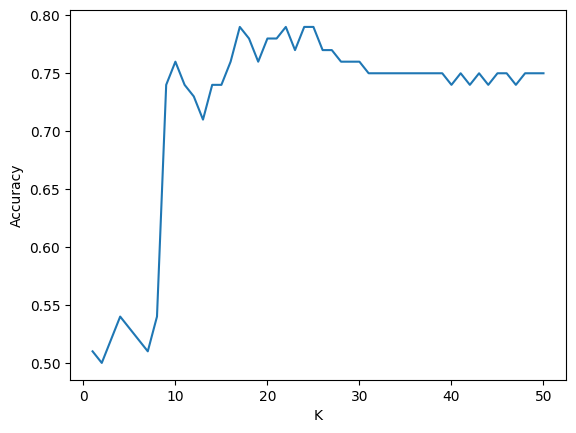

In [16]:
#Create the DataFrame to store the results
accuracy_to_k_dependency = pd.DataFrame()
accuracy_to_k_dependency['K'] = []
accuracy_to_k_dependency['Accuracy'] = []

#Here we will store the accuracy for the best K
max_accuracy = 0
max_accuracy_k = 0

#Run the k-NN algorith for K from 1-50
for i in range(1,51):
  knn = KNN(nb_features, nb_classes, train_data, i, weighted=False)
  accuracy = knn.predict({'x': test_x, 'y': test_y}) 
  if accuracy > max_accuracy:
    max_accuracy = accuracy
    max_accuracy_k = i
  accuracy_to_k_dependency.loc[i-1] = [i, accuracy]

#Create the plot to show how accuracy changes with making the K value bigger
plt.plot(accuracy_to_k_dependency['K'], accuracy_to_k_dependency['Accuracy'])

plt.xlabel("K")
plt.ylabel("Accuracy")

print("Best accuracy was: " + str(max_accuracy) + ", with K being: " + str(max_accuracy_k))

plt.show()

Obviously here the best accuracy was 0.79 as found by the algorithm measured with K being 17, which we can also see from the graph. The best jump was from around 7-10, and then there a peak at 17. As we make the K bigger the accuracy slowly starts to drop and stabilizes at around 0.75 going up and down.

# 3 c.py

Best accuracy was: 0.83, with K being: 39


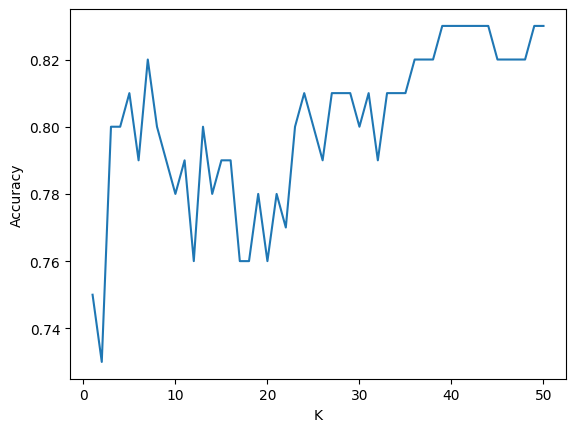

In [17]:
#Now we will run the same code with all the features from the dataset
train_dataset_final = one_hot_train_dataset.drop(['PassengerId'], axis=1)
test_dataset_final = one_hot_test_dataset.drop(['PassengerId'], axis=1)

train_x = train_dataset_final.drop(['Transported'], axis=1)
train_y = train_dataset_final.Transported

test_x = test_dataset_final.drop(['Transported'], axis=1)
test_y = test_dataset_final.Transported

train_data = {'x': train_x, 'y': train_y}
nb_features = train_x.shape[0] * train_x.shape[1]

accuracy_to_k_dependency = pd.DataFrame()
accuracy_to_k_dependency['K'] = []
accuracy_to_k_dependency['Accuracy'] = []

#Here we will store the accuracy for the best K
max_accuracy = 0
max_accuracy_k = 0

#Run the k-NN algorith for K from 1-50
for i in range(1,51):
  knn = KNN(nb_features, nb_classes, train_data, i, weighted=False)
  accuracy = knn.predict({'x': test_x, 'y': test_y}) 
  if accuracy > max_accuracy:
    max_accuracy = accuracy
    max_accuracy_k = i
  accuracy_to_k_dependency.loc[i-1] = [i, accuracy]

#Create the plot to show how accuracy changes with making the K value bigger
plt.plot(accuracy_to_k_dependency['K'], accuracy_to_k_dependency['Accuracy'])

plt.xlabel("K")
plt.ylabel("Accuracy")

print("Best accuracy was: " + str(max_accuracy) + ", with K being: " + str(max_accuracy_k))

plt.show()

This time we included all the features, and we see a different result. The accuracy improves and has a big jump earlier around 5-7(K), but then slowly starts dropping when it nears 20, Then it gradually improves again. We've gotten the best result for K = 39, but we see the same result was acquired with later values between around 39-43 and with values around 50.